In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
# Algorithms
import cma
from es import CMAES, OpenES
# Run the fitness 
from oct2py import Oct2Py
from multiprocessing.pool import ThreadPool 
# Run multiple Zs as different processes
from multiprocessing import Pool
# to save the progress of the algorithms
import csv
from datetime import datetime
from os import mkdir

In [2]:
# -------- range of the variables ----------
V_S = 8.0                   # service speed [kn]
range_D     = [0.5, 0.8]
range_AEdAO = [0.3, 1.05]
range_PdD   = [0.5, 1.4]
range_Z     = [2, 7]

# Define the lower and upper bounds for each variable
lower_bounds = [range_D[0], range_AEdAO[0], range_PdD[0]]
upper_bounds = [range_D[1], range_AEdAO[1], range_PdD[1]]

In [3]:
# CMAES
NPOPULATION   = 5  # size of population
MAX_ITERATION = 30 # run solver for this generations

NPARAMS = 3  # number of parameters to evaluate
SIGMA_INIT_CMAES    = 0.1

In [4]:
# seed for generating the random first element
SEED = 0

random.seed(SEED)
x0 =  [
        random.uniform(range_D[0],     range_D[1]),
        random.uniform(range_AEdAO[0], range_AEdAO[1]),
        random.uniform(range_PdD[0],   range_PdD[1])
      ]

print("D    ", x0[0])
print("AEdAO", x0[1])
print("PdD  ", x0[2])

D     0.7533265554575145
AEdAO 0.868465802205227
PdD   0.8785144227477605


In [6]:
save_file = True

if save_file:    
    # create main_date dir
    now = datetime.now()
    main_dir_name = 'main_' + now.strftime("%Y_%m_%d_%H_%M")
    try:
        mkdir(main_dir_name)
    except: pass
    # save the configs in a file
    filename = main_dir_name+'/' + 'configs.csv'
    with open(filename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow( ["V_S",            V_S] )
            writer.writerow( ["NPOPULATION",    NPOPULATION] )
            writer.writerow( ["MAX_ITERATION",  MAX_ITERATION] )
            writer.writerow( ["SEED",           SEED] )
            writer.writerow( ["x0 D",           x0[0]] )
            writer.writerow( ["x0 AEdAO",       x0[1]] )
            writer.writerow( ["x0 PdD",         x0[2]] )
            writer.writerow( ["SIGMA_INIT_CMAES",SIGMA_INIT_CMAES] )


In [16]:
# -- functions to save a file and create a dir --
def append_to_file(filename, row):
    with open(filename, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(row)

def append_to_file_order(filename, D='', AEdAO='', PdD='', Z='', P_B='', n='', fitness=''):
    row = [D, AEdAO, PdD, Z, P_B, n, fitness]
    with open(filename, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(row)

def create_file(dir_solver, text):
    filename = dir_solver+'/' + text +'.csv'
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        header = ["D = propeller diameter [m]",
                  "AEdAO = expanded area ratio",
                  "PdD = pitch ratio",
                  "Z = propeller's number of blades",
                  "P_B = power brake",
                  "n = Propeller angular speed [rpm]",
                  "fitness",
                  "t075dD",
                  "tmin075dD",
                  "tal07R",
                  "cavLim",
                  "Vtip",
                  "Vtipmax",
                  "penalty",
                  "valid"
                 ]
        writer.writerow(header)
    return filename

def create_dir(text):
    now = datetime.now()
    dir_name = './' + text +'_'+ now.strftime("%Y_%m_%d_%H_%M")
    try:
        mkdir(dir_name)
    except: pass
    return dir_name

def save_best_result(dir_seed, solver_name, V_S, Npop, Mit, seed, D, Z, AEdAO, PdD, fitness, P_B='', n='', history=''):
    # create the csv file with the headers
    fitness = -fitness
    Z = int(Z)
    filename = create_file(dir_seed, 'best_results_' + str(seed) +'_'+ solver_name)
    append_to_file_order(filename, D=D, AEdAO=AEdAO, PdD=PdD, Z=Z, P_B=P_B, n=P_B, fitness=fitness)
    # history
    append_to_file(filename, ['history'])
    append_to_file(filename, history)
    # config
    append_to_file(filename, ['solver Name', 'V_S', 'NPOPULATION', 'MAX_ITERATION', 'SEED'])
    append_to_file(filename, [ solver_name,    V_S,  Npop,         Mit,            seed])

    print('saved', filename)


Fitness and Evaluation

In [8]:
# run the Octave script to get the power brake for the params
def run_octave_evaluation(V_S,D,Z,AEdAO,PdD):
    P_B, t075dD,tmin075dD, tal07R,cavLim, Vtip,Vtipmax = [-1, -1, -1, -1, -1, -1, -1]
    with Oct2Py() as octave:
        octave.warning ("off", "Octave:data-file-in-path");
        octave.addpath('./allCodesOctave');
        P_B, n, etaO,etaR, t075dD,tmin075dD, tal07R,cavLim, Vtip,Vtipmax = octave.F_LabH2_return_constraints(V_S,D,Z,AEdAO,PdD, nout=10)
    return [P_B, t075dD,tmin075dD, tal07R,cavLim, Vtip,Vtipmax]

In [9]:
# fitness function, to find the minimal power brake
def evaluate_solution(x):
    D     = x[0]
    AEdAO = x[1]
    PdD   = x[2]

#     P_B, t075dD,tmin075dD, tal07R,cavLim, Vtip,Vtipmax
    P_B, strength,strengthMin, cavitation,cavitationMax, velocity,velocityMax = run_octave_evaluation(V_S,D,Z,AEdAO,PdD)

    # Fitness is Power Brake multiplied by 1 + the percentage of each constraint
    fit_value = P_B * (1 + max(((cavitation - cavitationMax)/cavitationMax), 0) + max(((velocity - velocityMax)/velocityMax), 0) + max(((strengthMin - strength)/strengthMin), 0) )

    # we want the minimal P_B
    # the solvers use the max value as best fitness, so
    fit_value *= -1

    # save to the file
    if save_file:
        penalty = max(((cavitation - cavitationMax)/cavitationMax), 0) + max(((velocity - velocityMax)/velocityMax), 0) + max(((strengthMin - strength)/strengthMin), 0)
        valid = (penalty == 0)
        append_to_file(filename, [D, AEdAO, PdD, Z, P_B, 0, fit_value, strength,strengthMin, cavitation,cavitationMax, velocity,velocityMax, penalty, valid])

    return fit_value


In [10]:
# use evaluate_solution as the fitness function
fit_func = evaluate_solution

Run logic for each iteration of the solver

In [11]:

# defines a function to use solver to solve fit_func
def test_solver(solver):
    # history of the best fitness at each iteration (generation)
    history = np.zeros(MAX_ITERATION)
    for j in range(MAX_ITERATION):
        # ask for the population
        solutions = solver.ask()
        # create a list with the fitness
        fitness_list = np.zeros(solver.popsize)
        # parallel run of fitness evaluation
        with ThreadPool() as pool:
            id_solutions = [(i, solutions[i]) for i in range(len(solutions))]
            # wrapper to add the index of solution in the array, to the response of the ThreadPool
            # this keeps the fitness_list and solutions list in the same order (necessary)
            fit_func_parallel_wrapper = (lambda i, x: [i, fit_func(x)] )
            for result in pool.starmap(fit_func_parallel_wrapper, id_solutions, chunksize=4):
                i, fitness = result
                fitness_list[i] = fitness
        # pass the fitness to the solver so it can decide the best individual
        solver.tell(fitness_list)
        result = solver.result() # first element is the best solution, second element is the best fitness
        history[j] = result[1]   # best fitness
        # print the process name (Z) and the iteration, and save in the csv
        print('Z:',Z, "fitness at iteration", (j+1), result[1], flush=True)
        if save_file:
            append_to_file_order(filename, "fitness at iteration", j, fitness=result[1])
    # best solution at the end of the solver's run
    print("local optimum discovered by solver:\n", result[0])
    print("fitness score at this local optimum:", result[1])
    return (history, result[0])

solvers definition

In [19]:
# defines CMA-ES algorithm solver
cmaes = CMAES(NPARAMS,
              x0=x0,                     # initial parameters values to generate the population
              popsize=NPOPULATION,
              weight_decay=0.0,
              sigma_init = SIGMA_INIT_CMAES,
              lower_bounds=lower_bounds,
              upper_bounds=upper_bounds,
          )

(2_w,5mirr1)-aCMA-ES (mu_w=1.6,w_1=73%) in dimension 3 (seed=758382, Sun Jan  7 19:28:18 2024)


## Parallel Run

Logic

In [23]:
# run the especified solver for the z passed
def solver_for_Z(solver, z, dir_solver):
    global Z
    Z = z

    # create the csv file with the headers
    if save_file:
        global filename
        filename = create_file(dir_solver, str(Z))

    # run the solver
    history, best_solution = test_solver(solver)

    # print best solution
    D       = best_solution[0]
    AEdAO   = best_solution[1]
    PdD     = best_solution[2]
    fitness = history[-1]
    print("Z:",Z, "Best Solution:", best_solution, 'with fitness:', fitness)

    if save_file:
        # write best solution to file
        append_to_file(filename, ["Best Solution"])
        append_to_file_order(filename, D=D, AEdAO=AEdAO, PdD=PdD, Z=Z, fitness=fitness)

    return [Z, best_solution, fitness, history]

In [24]:
# each element of the list results is [Z, (D, AEdAO, PdD), fitness, history]
def get_best_result(results):
    # get result with best fitness
    best_result = max(results, key=(lambda x: x[2]))
    # print the values
    Z             =  best_result[0]
    D, AEdAO, PdD =  best_result[1]
    fitness       = -best_result[2]
    print("D:",D,"Z:",Z,"AEdAO:",AEdAO,"PdD:",PdD)
    print("fitness:",fitness)
    return best_result

CMAES parallel

In [25]:
if save_file:
    global dir_name
    dir_name = create_dir('cmaes')

solver = cmaes
results_cmaes = []
# create a new process for to run each Z
with Pool() as pool:
    solver_zs = [(solver, z, dir_name) for z in range(range_Z[0],range_Z[1]+1)]
    for result in pool.starmap(solver_for_Z, solver_zs):
        results_cmaes.append(result)

Z: 2 fitness at iteration 1 -155.28329600101432
Z: 7 fitness at iteration 1 -140.81096061107672
Z: 6 fitness at iteration 1 -138.8593241009689
Z: 5 fitness at iteration 1 -139.22062933534605
Z: 3 fitness at iteration 1 -147.7580290119651
Z: 4 fitness at iteration 1 -142.0946540584963
Z: 6 fitness at iteration 2 -136.12231391001689
Z: 4 fitness at iteration 2 -139.64704559037366
Z: 3 fitness at iteration 2 -145.6965787559565
Z: 2 fitness at iteration 2 -155.28329600101432
Z: 5 fitness at iteration 2 -136.59520772615082
Z: 7 fitness at iteration 2 -137.95341717063113
Z: 6 fitness at iteration 3 -136.12231391001689
Z: 3 fitness at iteration 3 -145.6965787559565
Z: 4 fitness at iteration 3 -139.64704559037366
Z: 5 fitness at iteration 3 -136.59520772615082
Z: 6 fitness at iteration 4 -136.12231391001689
Z: 7 fitness at iteration 3 -137.95341717063113
Z: 2 fitness at iteration 3 -155.2596748124995
Z: 3 fitness at iteration 4 -145.6965787559565
Z: 2 fitness at iteration 4 -155.2596748124995


In [26]:
# sort by Z
results_cmaes.sort(key=(lambda r: r[0]))

print("Best result cmaes")
best_result_cmaes = get_best_result(results_cmaes)

Best result cmaes
D: 0.7999981991413158 Z: 6 AEdAO: 0.8631866254328584 PdD: 0.7367355527088367
fitness: 136.12231391001689


In [27]:
for r in results_cmaes:
    print(r[0], '  P_B:', r[2])

2   P_B: -153.35821847050656
3   P_B: -145.6965787559565
4   P_B: -139.64704559037366
5   P_B: -136.59520772615082
6   P_B: -136.12231391001689
7   P_B: -137.95341717063113


In [28]:
valid_results_cmaes = []

for r in results_cmaes:
    Z             =  r[0]
    D, AEdAO, PdD =  r[1]
    fitness       = -r[2]
    print()
    print("D:",D,"Z:",Z,"AEdAO:",AEdAO,"PdD:",PdD)
    print("fitness:",fitness)
    # recalculate data for the found params
    P_B, t075dD,tmin075dD, tal07R,cavLim, Vtip,Vtipmax = run_octave_evaluation(V_S,D,Z,AEdAO,PdD)
    penalty = 0
        # Strenght Constraint
    if (t075dD < tmin075dD):
        penalty = tmin075dD - t075dD
        print('broke Strength', penalty)
        # Cavitation Constraint
    if (tal07R > cavLim):
        penalty = tal07R - cavLim
        print('broke Cavitation', penalty)
        # Peripherical Velocity Constraint
    if (Vtip > Vtipmax):
        penalty = Vtip - Vtipmax
        print('broke Velocity', penalty)
    print("real P_B:",P_B)
    # if real P_B is the same of the fitness found in the solver, then result is valid
    if fitness == P_B:
        valid_results_cmaes.append(r)


D: 0.7997384841994272 Z: 2 AEdAO: 1.013684280710129 PdD: 0.9242882948958203
fitness: 153.35821847050656
real P_B: 153.35821847050656

D: 0.7999981991413158 Z: 3 AEdAO: 0.8631866254328584 PdD: 0.7367355527088367
fitness: 145.6965787559565
real P_B: 145.6965787559565

D: 0.7999981991413158 Z: 4 AEdAO: 0.8631866254328584 PdD: 0.7367355527088367
fitness: 139.64704559037366
real P_B: 139.64704559037366

D: 0.7999981991413158 Z: 5 AEdAO: 0.8631866254328584 PdD: 0.7367355527088367
fitness: 136.59520772615082
real P_B: 136.59520772615082

D: 0.7999981991413158 Z: 6 AEdAO: 0.8631866254328584 PdD: 0.7367355527088367
fitness: 136.12231391001689
real P_B: 136.12231391001689

D: 0.7999981991413158 Z: 7 AEdAO: 0.8631866254328584 PdD: 0.7367355527088367
fitness: 137.95341717063113
real P_B: 137.95341717063113


In [29]:
for r in valid_results_cmaes:
    print(r[0], '  P_B:', r[2])

2   P_B: -153.35821847050656
3   P_B: -145.6965787559565
4   P_B: -139.64704559037366
5   P_B: -136.59520772615082
6   P_B: -136.12231391001689
7   P_B: -137.95341717063113


In [30]:
print("Best result cmaes")
best_result_cmaes = get_best_result(valid_results_cmaes)

Best result cmaes
D: 0.7999981991413158 Z: 6 AEdAO: 0.8631866254328584 PdD: 0.7367355527088367
fitness: 136.12231391001689


In [31]:
best_result_cmaes

[6,
 array([0.7999982 , 0.86318663, 0.73673555]),
 -136.12231391001689,
 array([-138.8593241 , -136.12231391, -136.12231391, -136.12231391,
        -136.12231391, -136.12231391])]

## Save the best result

In [39]:
def save_best_result(result, solver_name, seed=None):
    # create the csv file with the headers
    global filename
    if seed != None:
        filename = create_file(dir_name, 'best_results_' + str(seed) + '_' + solver_name)
    else:
        filename = create_file(dir_name, 'best_results_' + solver_name)
    #
    Z             = result[0]
    D, AEdAO, PdD = result[1]
    fitness       = result[2]
    append_to_file_order(filename, D=D, AEdAO=AEdAO, PdD=PdD, Z=Z, fitness=fitness)
    # if there is history to save
    if (len(result) > 2):
        history   = result[3]
        append_to_file(filename, ['history'])
        append_to_file(filename, history)

In [40]:
save_best_result(best_result_cmaes, 'cmaes')
print('saved')

saved


## Analise

In [41]:
# creates a figure for a list of tuples (label, history)
def create_history_fig(labels, histories):
    # Create a new figure
    plt.figure(figsize=(16,8), dpi=150)

    lines = []
    for i in  range(len(histories)):
        label_h = labels[i]
        history = histories[i]
        history = np.negative(history)
        line, = plt.plot(history, linewidth=1.0, label=label_h)
        lines.append(line)
        
    plt.legend(handles=lines, loc=4)

    # Set x limits
    # plt.xlim(0,50)

    plt.xlabel('generation')
    plt.ylabel('fitness')

    # plt.savefig("./output_image.svg")

    plt.show()

CMA-ES


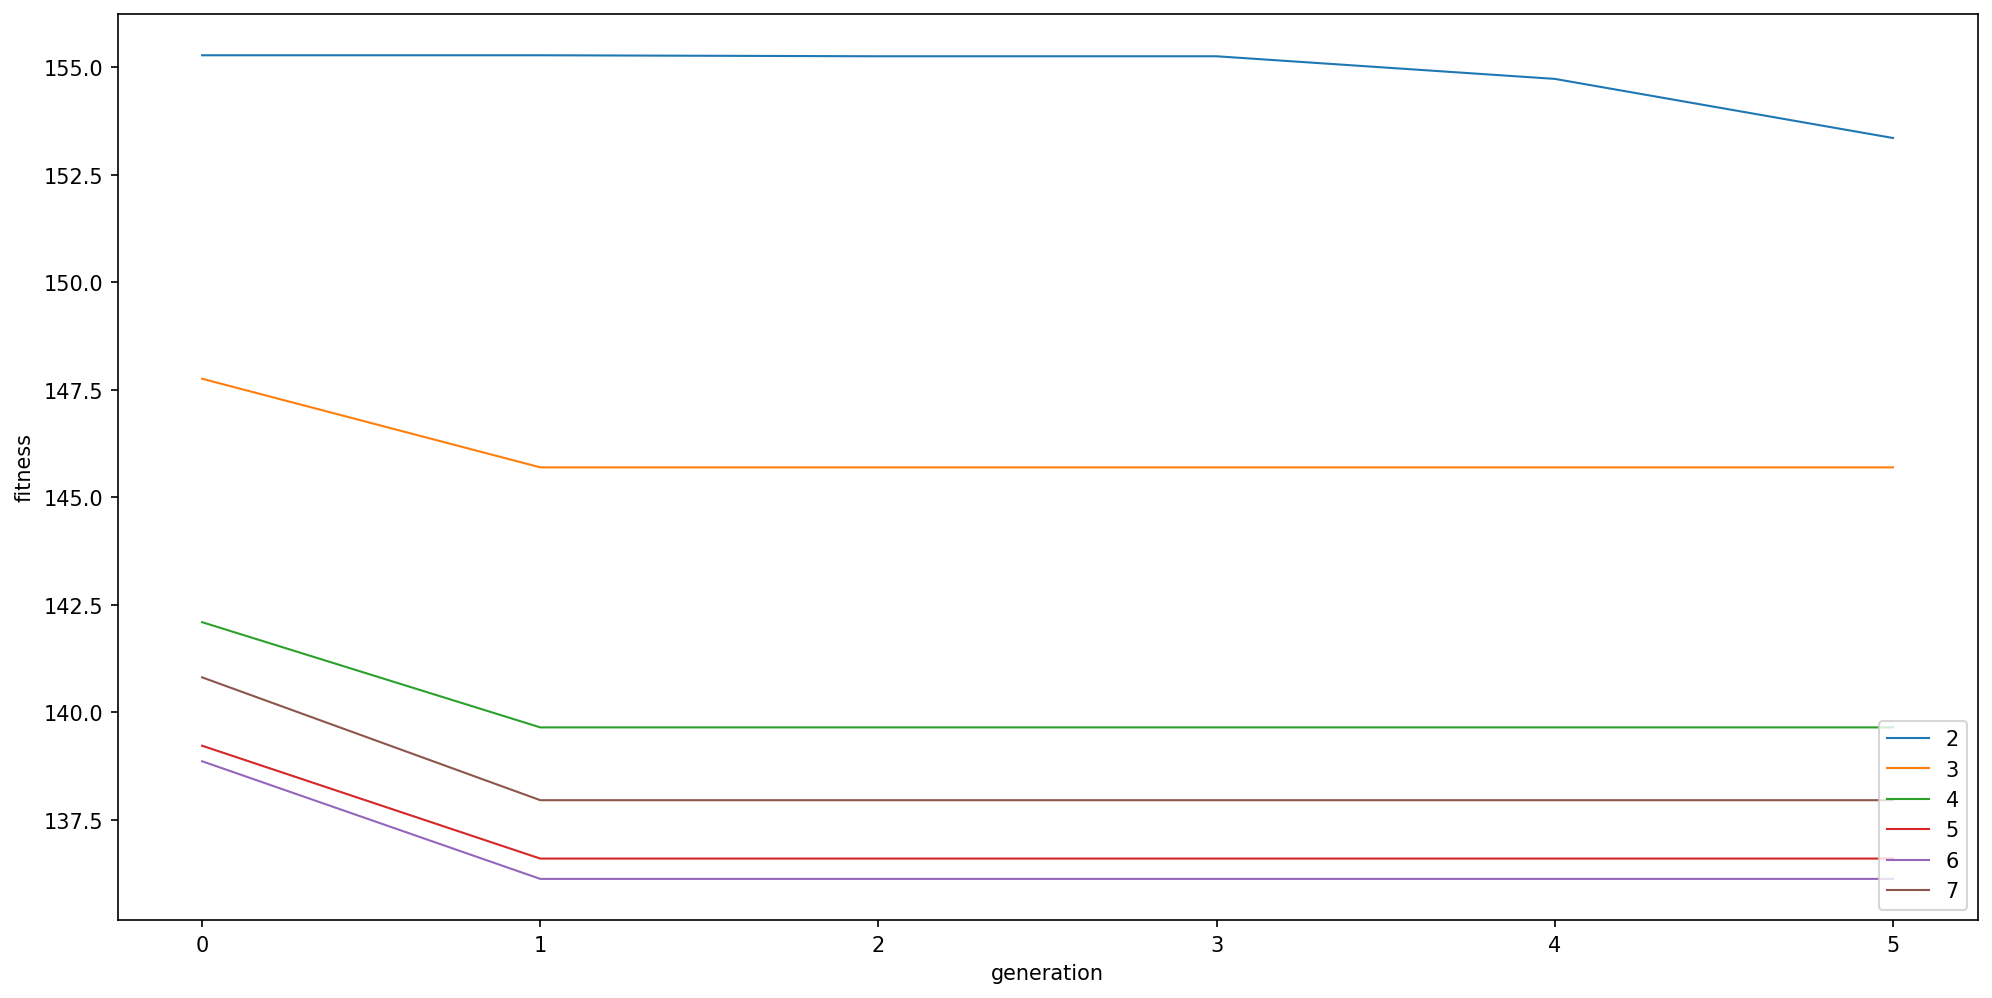

In [42]:
print("CMA-ES")
# Label each Z
labels          = [str(r[0])     for r in results_cmaes]
fitnesses_cmaes = np.array([r[3] for r in results_cmaes])
# create image with Z's as labels
create_history_fig(labels, fitnesses_cmaes)